In [2]:
import numpy as np
import cv2
import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [3]:
image_paths = glob.glob(r"C:\Users\DELL\Downloads\ML_project\jpg\*.jpg")

image_paths = sorted(
    image_paths,
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

print("Number of images:", len(image_paths))


Number of images: 8189


In [4]:
labels_mat = loadmat(r"C:\Users\DELL\Downloads\ML_project\imagelabels.mat")
labels = labels_mat["labels"][0]

print("Number of labels:", len(labels))


Number of labels: 8189


In [6]:
print(labels_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'labels'])


In [7]:
IMG_SIZE = 128

images = []

for path in image_paths:
    img = cv2.imread(path)

    if img is None:
        continue  # safety check

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    images.append(img)

images = np.array(images)
print(images.shape)


(8189, 128, 128, 3)


In [14]:
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))

# Sort classes by frequency (descending)
sorted_class_counts = dict(
    sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
)

selected_classes = list(sorted_class_counts.keys())[:5]
print("Selected classes:", selected_classes)
print(len(selected_classes))

Selected classes: [np.uint8(51), np.uint8(77), np.uint8(46), np.uint8(73), np.uint8(89)]
5


In [9]:
IMG_SIZE = 128

filtered_images = []
filtered_labels = []

for img, label in zip(images, labels):
    if label in selected_classes:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        filtered_images.append(img)
        filtered_labels.append(label)

filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

print("Filtered images:", filtered_images.shape)


Filtered images: (1083, 128, 128, 3)


In [15]:
label_map = {cls: i for i, cls in enumerate(selected_classes)}
new_labels = np.array([label_map[l] for l in filtered_labels])

print("New label set:", np.unique(new_labels))


New label set: [0 1 2 3 4]


In [10]:
X = []

for img in filtered_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(
        gray,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        feature_vector=True
    )
    X.append(features)

X = np.array(X)
print("Feature matrix shape:", X.shape)


Feature matrix shape: (1083, 8100)


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    new_labels,
    test_size=0.2,
    stratify=new_labels,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (866, 8100)
Test shape: (217, 8100)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss


In [22]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [23]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1,
    warm_start=True
)
#log_reg.fit(X_train, y_train)

In [24]:
losses = []
epochs = 100

for _ in range(epochs):
    log_reg.fit(X_train, y_train)
    y_prob = log_reg.predict_proba(X_train)
    losses.append(log_loss(y_train, y_prob))

In [25]:
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)


In [26]:
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)


Logistic Regression Accuracy: 0.6820276497695853


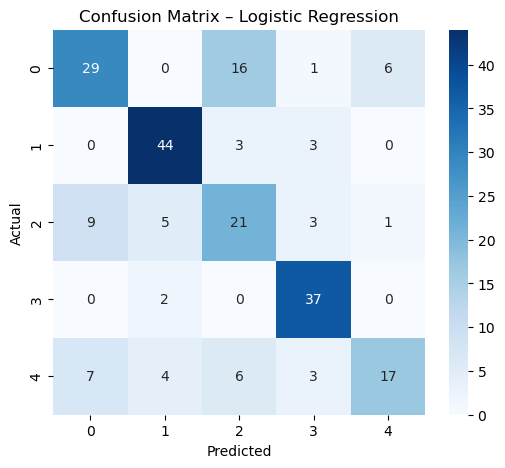

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("LR_CM.png", dpi=300, bbox_inches="tight")
plt.show()


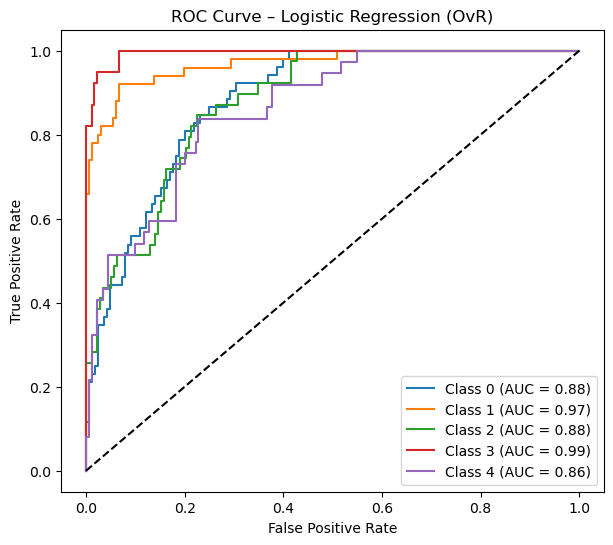

In [32]:
# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (OvR)")
plt.legend()
plt.savefig("roc.png", dpi=300, bbox_inches="tight")
plt.show()


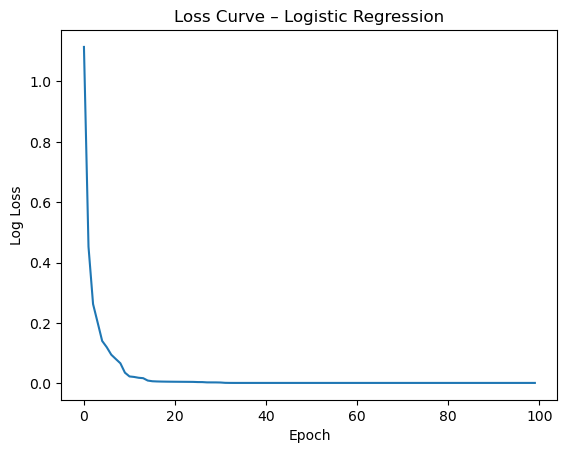

In [31]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Loss Curve – Logistic Regression")
plt.show()


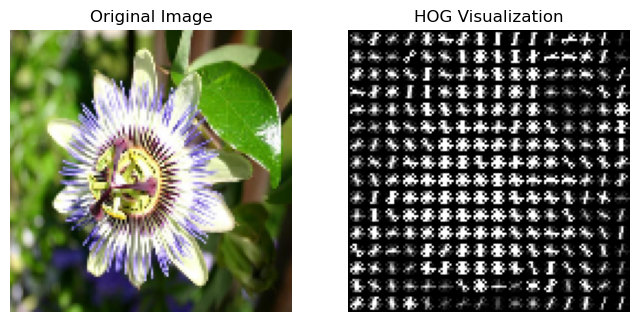

In [28]:

test_image = filtered_images[0]
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)


fd, hog_image = hog(
    test_image_gray,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,    
    feature_vector=True
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.axis('off')
ax1.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')


from skimage import exposure
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG Visualization')
plt.show()

In [29]:
print("Selected classes:", selected_classes)

Selected classes: [np.uint8(51), np.uint8(77), np.uint8(46), np.uint8(73), np.uint8(89)]


ID 51: Petunia

ID 77: Passion Flower

ID 46: Wallflower

ID 73: Water Lily

ID 89: Watercress